In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import mlflow
from mlflow import MlflowClient
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from mlflow.models import infer_signature
import plotly.express as px
from plotly import figure_factory
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# from utils import feature_names, convert_bool_to_int
import numpy as np
import math
import random


In [3]:

def check_domains(domain_list, blocklist, whitelist, filt_phish, filt_tranco):
    blocklist_matches = []#{'Matches': []}
    whitelist_matches = []#{'Matches': []}

    domain_series = pd.Series(domain_list)
    # if filt_phish(domain_list):
    for domain in domain_list:
        if filt_phish([domain]):
            matches = blocklist[blocklist == domain].tolist()
            if len(matches) > 0:
                blocklist_matches.extend(matches)
            #blocklist_matches["Matches"].extend(matches)
            if len(blocklist_matches) == 0:
                wildcard_pattern = domain.replace(".", r"\.").replace("*", r"[^.]*")
                matches = blocklist[blocklist.str.match(f"^{wildcard_pattern}$")].tolist()
                if len(matches) > 0:
                    blocklist_matches.extend(matches)

        if filt_tranco([domain]):
            # for domain in domain_list:
            matches = whitelist[whitelist == domain].tolist()
            if len(matches) > 0:
                whitelist_matches.extend(matches)
            # whitelist_matches["Matches"].extend(matches)
            if len(whitelist_matches) == 0:
                # for domain in domain_list:
                wildcard_pattern = domain.replace(".", r"\.").replace("*", r"[^.]*")
                matches = whitelist[whitelist.str.match(f"^{wildcard_pattern}$")].tolist()
                if len(matches) > 0:
                    whitelist_matches.extend(matches)

    return blocklist_matches, whitelist_matches


class Filter:
    def __init__(self, keep_names):
        self.keep_names = keep_names
        # add_keep_domain("OpenWrt", self.keep_names)
        # add_keep_domain("foo.ifjllc.com", self.keep_names)

    def __call__(self, names):
        for name in names:
            # for name in row["f"][1]["v"]:
            # if name['v'] in self.keep_names:
            return is_in_keep_domains(name, self.keep_names)


def add_keep_domain(domain: str, keep_domains: dict):
    reversed_parts = reversed(domain.split('.'))
    domain_node = keep_domains
    for part in reversed_parts:
        try:
            domain_node = domain_node[part]
        except KeyError:
            n_domain_node = dict()
            domain_node[part] = n_domain_node
            domain_node = n_domain_node

    domain_node["."] = domain


def is_in_keep_domains(domain: str, keep_domains: dict):
    reversed_parts = reversed(domain.split('.'))
    domain_node = keep_domains
    for part in reversed_parts:
        try:
            domain_node = domain_node[part]
        except KeyError:
            if part == '*':
                for domain, subdomains in domain_node.items():
                    if domain == '.':
                        continue
                    if '.' in subdomains:
                        return True
            return False

    return '.' in domain_node


def top_tranco():
    tranco_raw = pd.read_csv(filepath_or_buffer='/home/mha/PycharmProjects/thesis/bigQueryCode/tranco.csv', sep=',',
                             header=0)
    return tranco_raw.drop(tranco_raw[tranco_raw['rank'] > 20000].index)

def clean_block_list():
    phish = pd.read_csv(filepath_or_buffer='/home/mha/PycharmProjects/thesis/bigQueryCode/phishtank.csv', sep=',',
                        header=0)
    phish['verification_time'] = pd.to_datetime(phish['verification_time'])
    phish = phish[phish['verification_time'].dt.year == 2023]
    phish[['protocol', 'urlNoProto']] = phish['url'].str.split('://', expand=True, n=1)
    phish = phish.drop(phish[phish.protocol == "http"].index)
    phish.reset_index(inplace=True)
    phish[['fullDomain', 'path']] = phish['urlNoProto'].str.split('/', expand=True, n=1)
    phish = phish.drop(phish[phish['fullDomain'].str.endswith('google.com')].index)
    phish = phish.drop(phish[phish['fullDomain'].str.endswith('amazonaws.com')].index)
    phish = phish.drop(phish[phish['fullDomain'].str.endswith('godaddysites.com')].index)
    phish = phish.drop(phish[phish['fullDomain'].str.endswith('weeblysite.com')].index)
    phish = phish.drop(phish[phish['fullDomain'].str.endswith('mybluehost.me')].index)
    phish = phish.drop(phish[phish['fullDomain'].str.endswith('inmotionhosting.com')].index)
    phish = phish.drop(phish[phish['fullDomain'].str.endswith('firebaseapp.com')].index)
    phish = phish.drop(phish[phish['fullDomain'].str.endswith('googleapis.com')].index)
    phish = phish.drop(phish[phish['fullDomain'].str.endswith('azurefd.net')].index)
    phish.reset_index(inplace=True)
    phish['fullDomain'] = phish['fullDomain'].str.replace('www.', '')
    return phish

def create_phish_set():
    block_list = clean_block_list()
    s = block_list['fullDomain'].unique()

    keep_domains = dict()
    for domain in s:
        add_keep_domain(domain, keep_domains)
    return keep_domains

def create_tranco_set():
    tranco = top_tranco()
    s = set(tranco['domain'].unique())

    keep_domains = dict()
    for domain in s:
        add_keep_domain(domain, keep_domains)
    return keep_domains

In [4]:
df = pd.read_pickle("/home/mha/PycharmProjects/thesis/filteredCertPrufa.pkl")

In [5]:
df

,names,serial_number,subject_common_name,subject_country,subject_locality,subject_province,subject_organization,subject_num_fields,apple_ever_valid,microsoft_ever_valid,...,authority_key_id,critical,in_tranco,in_phish,ocsp_urls,notice_numbers,directory_names,extended_key_usage,issuer_org,signed_certificate_timestamps
496,"[*.iherb.biz, iherb.biz]",400977141667832960674207135558527647498263,*.iherb.biz,,,,,1,True,True,...,True,None,False,False,True,-1,[],True,Let's Encrypt,[]
504,"[*.flashscore.co, flashscore.co]",311390029314026084051114153613681964773357,*.flashscore.co,,,,,1,True,True,...,True,None,False,False,True,-1,[],True,Let's Encrypt,[]
515,[denkc.shop],366504857763249856277849125738975780317575,denkc.shop,,,,,1,True,True,...,True,None,False,True,True,-1,[],True,Let's Encrypt,"[{'version': 0, 'log_id': b'\xb7>\xfb$\xdf\x9c..."
701,"[uspick.top, uspicu.top, uspidi.top, uspikh.to...",292256474545241961098923632371890089111625,ususcu.top,,,,,1,True,True,...,True,None,False,False,True,-1,[],True,Let's Encrypt,"[{'version': 0, 'log_id': b'z2\x8cT\xd8\xb7-\x..."
702,"[*.escortbabylon.net, escortbabylon.net]",197551658745025791587170417371140587467,escortbabylon.net,,,,,1,True,True,...,True,None,False,False,True,-1,[],True,Google Trust Services LLC,"[{'version': 0, 'log_id': b'z2\x8cT\xd8\xb7-\x..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992555,"[dl.hitava.ir, hitava.ir, manager.hitava.ir]",21792345402629533913784223078269556652123531,hitava.ir,,,,,1,False,False,...,True,None,False,False,True,-1,[],True,(STAGING) Let's Encrypt,[]
1892750,"[dl.hitava.ir, hitava.ir, manager.hitava.ir]",21804024841136539501837843257813772654259931,hitava.ir,,,,,1,False,False,...,True,None,False,False,True,-1,[],True,(STAGING) Let's Encrypt,[]
619010,"[dl.hitava.ir, hitava.ir, manager.hitava.ir]",405201714776568121846187284932507646748667,hitava.ir,,,,,1,True,True,...,True,None,False,False,True,-1,[],True,Let's Encrypt,"[{'version': 0, 'log_id': b'\xb7>\xfb$\xdf\x9c..."
840578,"[dl.hitava.ir, hitava.ir, manager.hitava.ir]",21817090175265403469026919976137964572235169,hitava.ir,,,,,1,False,False,...,True,None,False,False,True,-1,[],True,(STAGING) Let's Encrypt,[]


In [6]:

blocklist = clean_block_list()["fullDomain"]
whitelist = top_tranco()["domain"]
print(df.shape)
filt_phish = Filter(create_phish_set())
filt_tranco = Filter(create_tranco_set())
df[['phish_matches', 'tranco_matches']] = df['names'].apply(
    lambda x: pd.Series(check_domains(x, blocklist, whitelist, filt_phish, filt_tranco),
                        index=['phish_matches', 'tranco_matches'])
)
print(df.columns)
df.reset_index(drop=True, inplace=True)
df['phish_matches'] = df['phish_matches'].apply(lambda x: list(set(x)))
df['tranco_matches'] = df['tranco_matches'].apply(lambda x: list(set(x)))


/tmp/ipykernel_2639169/2092036625.py:104: FutureWarning: The default value of regex will change from True to False in a future version.
  phish['fullDomain'] = phish['fullDomain'].str.replace('www.', '')


(79196, 39)


KeyboardInterrupt: 

In [ ]:
df[((df['tranco_matches'].apply(lambda x: len(x) == 1)) & (df['phish_matches'].apply(lambda x: len(x) == 1)))].subject_common_name.unique()

In [ ]:
df[((df['tranco_matches'].apply(lambda x: len(x) == 0)) & (df['phish_matches'].apply(lambda x: len(x) == 0)))]

In [ ]:
df

In [ ]:
filtered_cond = df[
    (df['phish_matches'].apply(lambda x: len(x) > 1))
    | (df['tranco_matches'].apply(lambda x: len(x) > 1))
    | ((df['tranco_matches'].apply(lambda x: len(x) == 0)) & (df['phish_matches'].apply(lambda x: len(x) == 0)))
    | ((df['tranco_matches'].apply(lambda x: len(x) == 1)) & (df['phish_matches'].apply(lambda x: len(x) == 1)))]
filtered_df = df.drop(filtered_cond.index)
filtered_df = df
filtered_df['phish'] = filtered_df['phish_matches'].apply(lambda x: label_phish(x))
filtered_df['tranco'] = filtered_df['tranco_matches'].apply(lambda x: label_phish(x))

# Analyse repeated subject common name

In [110]:
df_all = pd.read_pickle("/home/mha/PycharmProjects/thesis/certPrufa.pkl")

In [111]:
df_all

,names,serial_number,subject_common_name,subject_country,subject_locality,subject_province,subject_organization,subject_num_fields,apple_ever_valid,microsoft_ever_valid,...,authority_key_id,critical,in_tranco,in_phish,ocsp_urls,notice_numbers,directory_names,extended_key_usage,issuer_org,signed_certificate_timestamps
0,"[imperva.com, isupply.aosmd.com]",2082266669562170834181269596218225625,imperva.com,,,,,1,True,True,...,True,None,True,False,True,-1,[],1.0,GlobalSign nv-sa,[]
1,"[dpc-api.energia.vodafone.es, imperva.com]",2272355067272594184410386963022948535,imperva.com,,,,,1,True,True,...,True,None,False,False,True,-1,[],True,GlobalSign nv-sa,[]
2,"[*.integration.covermymeds.com, imperva.com]",2470670144249306740938704202076214053,imperva.com,,,,,1,True,True,...,True,None,False,False,True,-1,[],True,GlobalSign nv-sa,[]
3,[*.dev.dataland.interfaces.boehringer-ingelhei...,2065487224227830948370047771729553234,imperva.com,,,,,1,True,True,...,True,None,False,False,True,-1,[],True,GlobalSign nv-sa,[]
4,"[imperva.com, preprod.bereavementadvice.org]",1729628047536146748161024692420494903,imperva.com,,,,,1,True,True,...,True,None,True,False,True,-1,[],True,GlobalSign nv-sa,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899996,"[imperva.com, www.kapowdesignhosting.com]",1686067692357635054083188956325634206,imperva.com,,,,,1,True,True,...,True,None,True,False,True,-1,[],True,GlobalSign nv-sa,[]
1899997,"[aa4.shop10.store, imperva.com]",1986188466771487319549593781746920111,imperva.com,,,,,1,True,True,...,True,None,False,False,True,-1,[],True,GlobalSign nv-sa,[]
1899998,"[*.wabicar-portal.es, imperva.com]",1687178750197734142287184853728446658,imperva.com,,,,,1,True,True,...,True,None,False,False,True,-1,[],True,GlobalSign nv-sa,[]
1899999,"[imperva.com, www.boothking.ca]",2383986453065417106244935894235108966,imperva.com,,,,,1,True,True,...,True,None,True,False,True,-1,[],True,GlobalSign nv-sa,[]


In [194]:
count_of_counts = df_all["subject_common_name"].value_counts().value_counts()

In [195]:
count_of_counts_sorted = count_of_counts.sort_index()

In [149]:
count_of_counts_sorted.values

array([19866,  5463,  2947,  1768,  1084,   596,   404,   207,   152,
         107,    81,    71,    50,    35,    31,    31,    23,    23,
          14,    15,    11,    15,    16,     9,     8,     8,     5,
           6,     8,     6,     4,     7,     7,     4,     6,     6,
          14,    10,    12,    17,    16,    13,    15,     8,    18,
          19,    15,    16,    17,    10,    10,     8,    10,    10,
          10,     6,     2,     4,     4,     3,     2,     3,     2,
           3,     2,     2,     2,     2,     1,     1,     1,     1,
           1,     2,     2,     1,     1,     1,     1,     2,     2,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           2,     2,     1,     2,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,

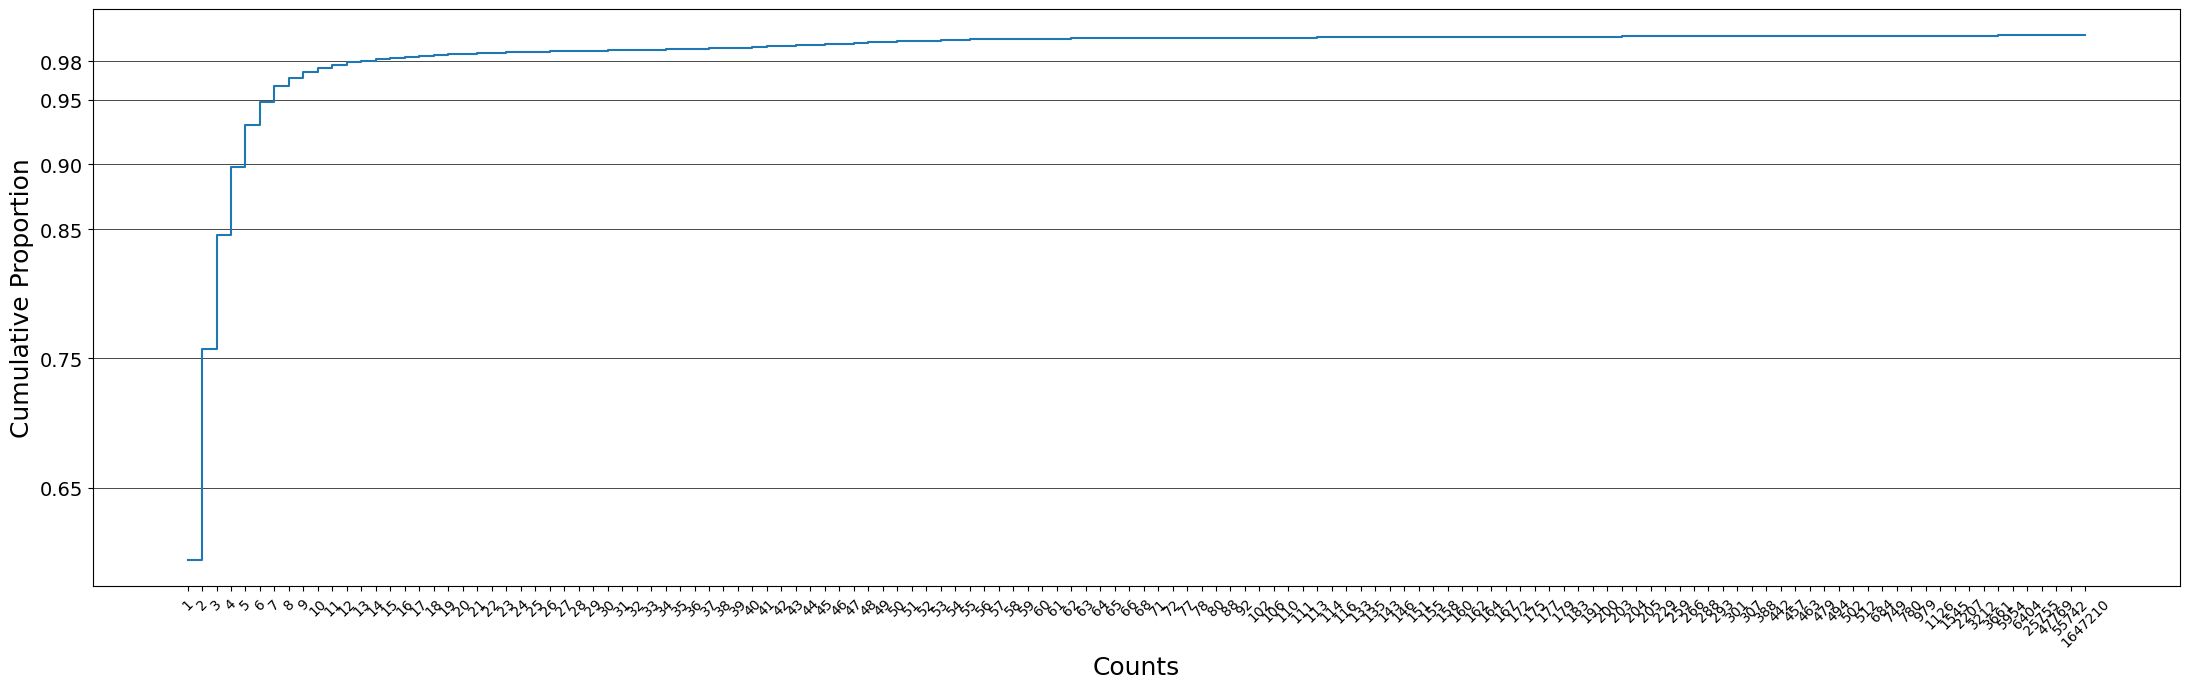

In [196]:
cumulative_freq = np.cumsum(count_of_counts_sorted.values)
total_freq = np.sum(count_of_counts_sorted.values)

# Calculate cumulative probabilities
cumulative_prob = cumulative_freq / total_freq
categories_values = count_of_counts_sorted.index
categories = [str(value) for value in count_of_counts_sorted.index]
plt.figure(figsize=(22, 7))  # Adjust the width and height (in inches) as needed
# Create the CDF plot
plt.step(categories, cumulative_prob, where='post')

percentiles = [ 0.65, 0.75, 0.85, 0.9, 0.95, 0.98]
plt.yticks(percentiles, fontsize=14)
# Add labels and title
plt.xlabel('Counts', fontsize=18)
plt.xticks(categories[::],rotation=45, fontsize=10)  # Adjust the rotation angle and alignment as needed
plt.ylabel('Cumulative Proportion', fontsize=18)
plt.grid(axis='y')
plt.gca().yaxis.grid(True, which='major', color='black', linestyle='-', linewidth=0.5)
plt.gca().set_yticks(percentiles, minor=True)
plt.tight_layout()

# Show the plot
# plt.savefig("cdfBeforeDrop.pdf", bbox_inches="tight")
plt.show()

In [197]:
cumulative_prob

array([0.59390135, 0.75721973, 0.84532138, 0.89817638, 0.93058296,
       0.9484006 , 0.96047833, 0.96666667, 0.97121076, 0.97440957,
       0.97683109, 0.97895366, 0.98044843, 0.98149477, 0.98242152,
       0.98334828, 0.98403587, 0.98472347, 0.985142  , 0.98559043,
       0.98591928, 0.98636771, 0.98684604, 0.9871151 , 0.98735426,
       0.98759342, 0.9877429 , 0.98792227, 0.98816143, 0.98834081,
       0.98846039, 0.98866966, 0.98887892, 0.98899851, 0.98917788,
       0.98935725, 0.98977578, 0.99007474, 0.99043348, 0.9909417 ,
       0.99142003, 0.99180867, 0.9922571 , 0.99249626, 0.99303438,
       0.99360239, 0.99405082, 0.99452915, 0.99503737, 0.99533632,
       0.99563528, 0.99587444, 0.99617339, 0.99647235, 0.9967713 ,
       0.99695067, 0.99701046, 0.99713004, 0.99724963, 0.99733931,
       0.9973991 , 0.99748879, 0.99754858, 0.99763827, 0.99769806,
       0.99775785, 0.99781764, 0.99787743, 0.99790732, 0.99793722,
       0.99796712, 0.99799701, 0.99802691, 0.9980867 , 0.99814

In [182]:
np.percentile(count_of_counts_sorted, 90)

34.60000000000002

34.60000000000002


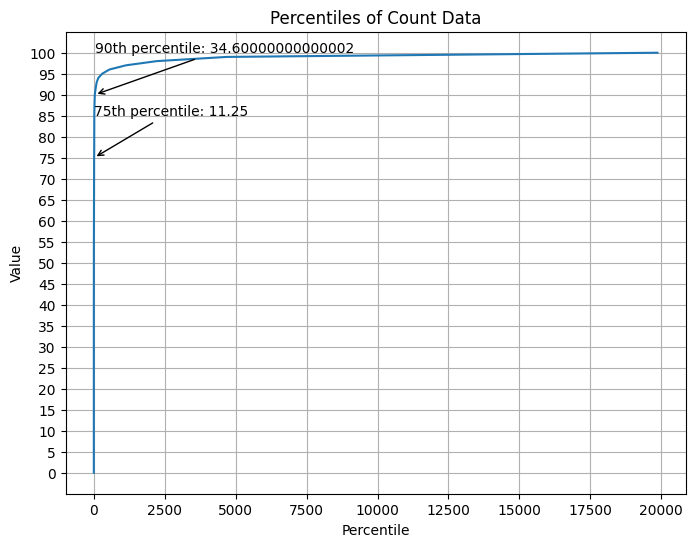

In [183]:
percentiles = np.percentile(count_of_counts_sorted, range(0, 101))

# Plotting percentiles
plt.figure(figsize=(8, 6))
plt.plot(percentiles,range(0, 101), linestyle='-')
plt.xlabel('Percentile')
plt.ylabel('Value')
plt.title('Percentiles of Count Data')
plt.grid(True)
plt.yticks(np.arange(0, 100+1, 5))
percentile_75 = np.percentile(count_of_counts_sorted, 75)
plt.annotate(f'75th percentile: {percentile_75}', xy=(percentile_75, 75), xytext=(percentile_75 + 10, 75 + 10),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
percentile_90 = np.percentile(count_of_counts_sorted, 90)
print(percentile_90)
plt.annotate(f'90th percentile: {percentile_90}', xy=(percentile_90, 90), xytext=(percentile_90 + 10, 90 + 10),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.show()

In [136]:
categories[::5]

['1',
 '6',
 '11',
 '16',
 '21',
 '26',
 '31',
 '36',
 '41',
 '46',
 '51',
 '56',
 '61',
 '66',
 '78',
 '106',
 '116',
 '151',
 '164',
 '179',
 '204',
 '288',
 '442',
 '502',
 '979',
 '3661',
 '55742']

In [157]:
np.percentile(count_of_counts_sorted.index, 98)

34120.3199999999

In [14]:
def balance_dataset(cert_df):
    common_name_counts = cert_df['subject_common_name'].value_counts().to_dict()
    count_of_counts = cert_df["subject_common_name"].value_counts().value_counts()
    cut_point = np.percentile(count_of_counts, 90)
    low_bound = np.percentile(count_of_counts, 75)

    new_df = cert_df.copy()
    for common_name in common_name_counts.keys():
        count = common_name_counts[common_name]
        if count > cut_point:
            sampling_num = random.randint(math.floor(low_bound), math.floor(cut_point))
            new_df.drop(new_df[new_df["subject_common_name"] == common_name].index, inplace=True)
            df_to_append = cert_df[cert_df["subject_common_name"] == common_name].sample(n=sampling_num)
            new_df = new_df.append(df_to_append)
    return new_df

In [184]:
df_balanced = balance_dataset(df_all)

In [185]:
count_of_counts = df_balanced["subject_common_name"].value_counts().value_counts()
count_of_counts_sorted = count_of_counts.sort_index()

In [189]:
np.percentile(count_of_counts, 75)

140.75

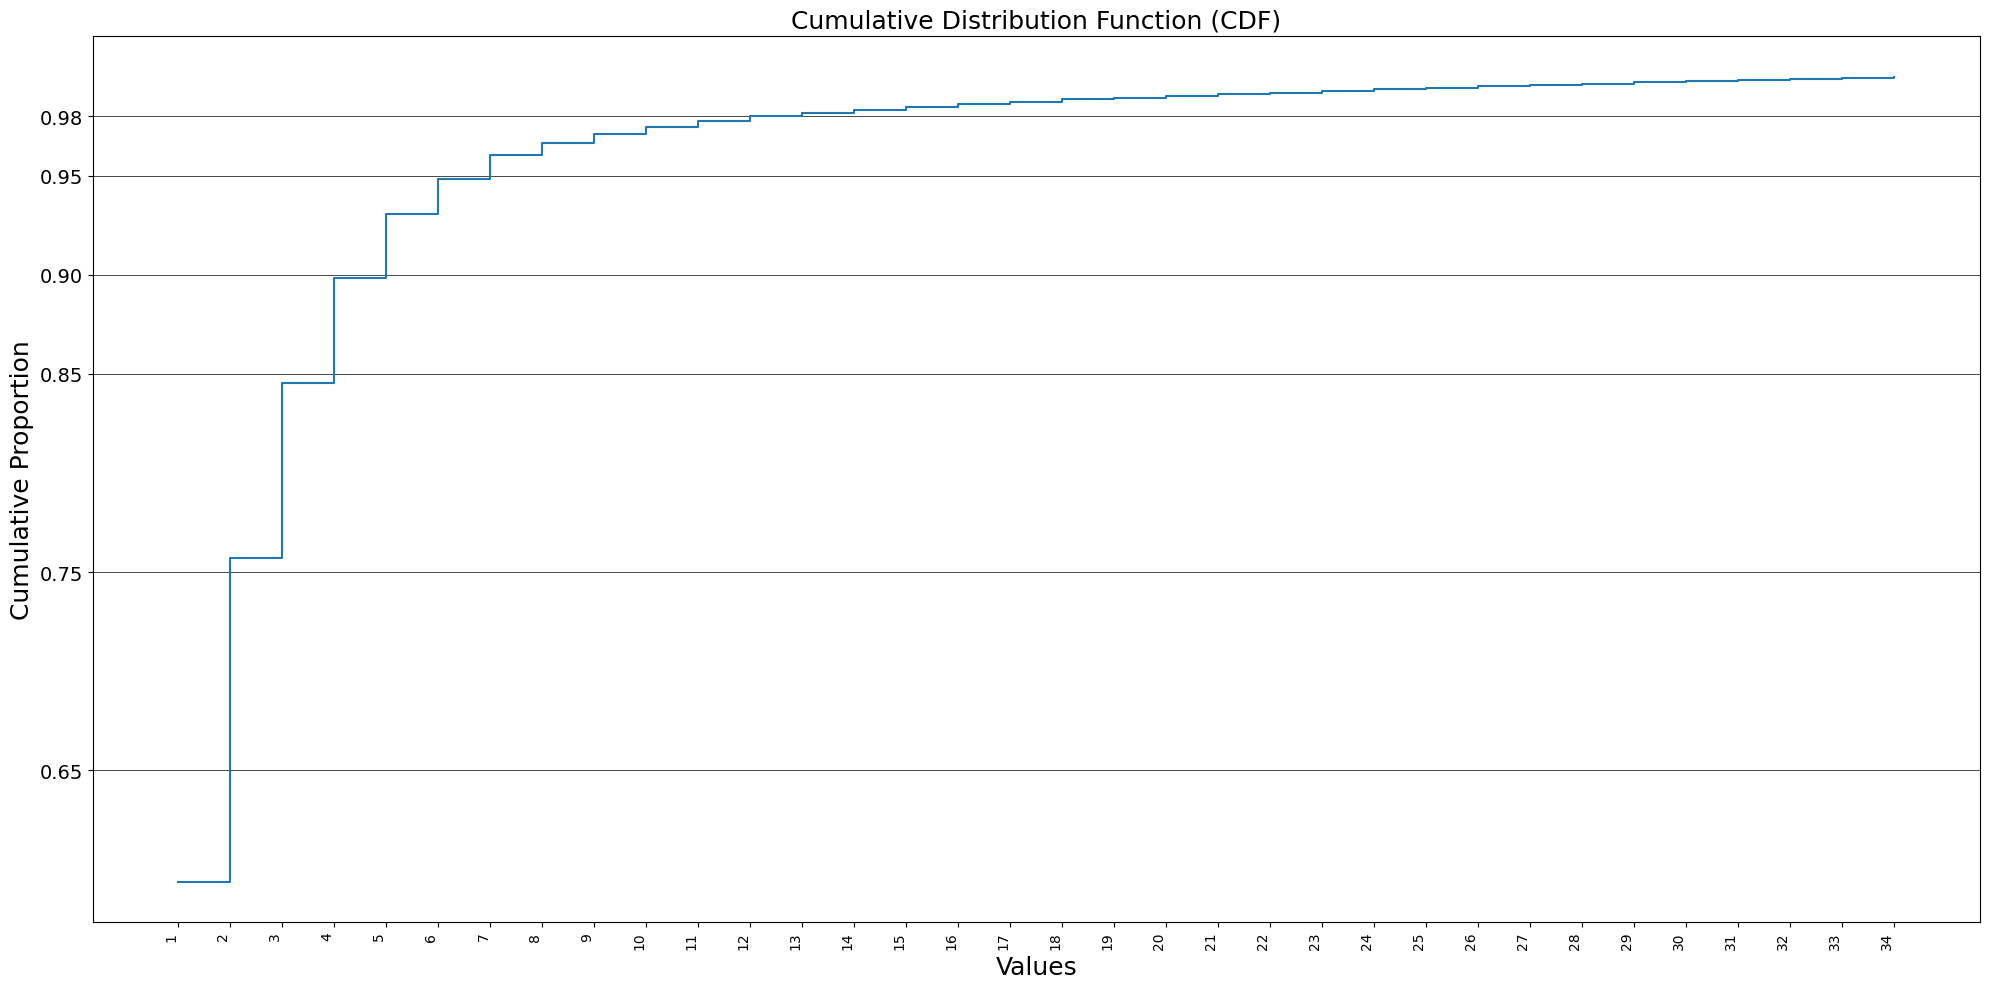

In [190]:
cumulative_freq = np.cumsum(count_of_counts_sorted.values)
total_freq = np.sum(count_of_counts_sorted.values)

# Calculate cumulative probabilities
cumulative_prob = cumulative_freq / total_freq
categories = [str(value) for value in count_of_counts_sorted.index]
plt.figure(figsize=(20, 10))  # Adjust the width and height (in inches) as needed
# Create the CDF plot
plt.step(categories, cumulative_prob, where='post')

percentiles = [ 0.65, 0.75, 0.85, 0.9, 0.95, 0.98]
plt.yticks(percentiles, fontsize=14)
# Add labels and title
plt.xlabel('Values', fontsize=18)
plt.xticks(rotation="vertical", ha='right')  # Adjust the rotation angle and alignment as needed
plt.ylabel('Cumulative Proportion', fontsize=18)
plt.title('Cumulative Distribution Function (CDF)', fontsize=18)
plt.grid(axis='y')
plt.gca().yaxis.grid(True, which='major', color='black', linestyle='-', linewidth=0.5)
plt.gca().set_yticks(percentiles, minor=True)
plt.tight_layout()

# Show the plot
# plt.savefig("cdfAfterDrop.pdf", bbox_inches="tight")
plt.show()

In [191]:
cumulative_prob

array([0.59390135, 0.75721973, 0.84532138, 0.89817638, 0.93058296,
       0.9484006 , 0.96047833, 0.96666667, 0.97121076, 0.97440957,
       0.977429  , 0.98      , 0.98182362, 0.98325859, 0.98475336,
       0.98615845, 0.98732436, 0.98863976, 0.98938714, 0.9903438 ,
       0.9909716 , 0.99180867, 0.99294469, 0.99378176, 0.99440957,
       0.99500747, 0.99569507, 0.99632287, 0.99704036, 0.99772795,
       0.99817638, 0.99874439, 0.9993423 , 1.        ])

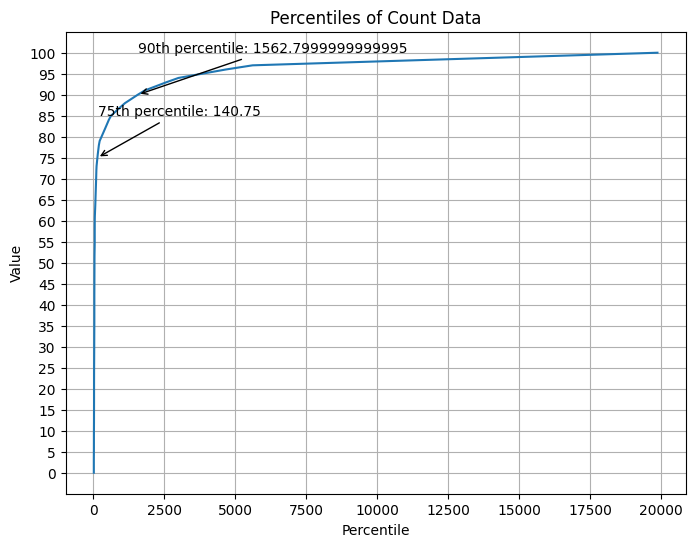

In [173]:
percentiles = np.percentile(count_of_counts_sorted, range(0, 101))

# Plotting percentiles
plt.figure(figsize=(8, 6))
plt.plot(percentiles,range(0, 101), linestyle='-')
plt.xlabel('Percentile')
plt.ylabel('Value')
plt.title('Percentiles of Count Data')
plt.grid(True)
plt.yticks(np.arange(0, 100+1, 5))
percentile_75 = np.percentile(count_of_counts_sorted, 75)
plt.annotate(f'75th percentile: {percentile_75}', xy=(percentile_75, 75), xytext=(percentile_75 + 10, 75 + 10),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
percentile_90 = np.percentile(count_of_counts_sorted, 90)
plt.annotate(f'90th percentile: {percentile_90}', xy=(percentile_90, 90), xytext=(percentile_90 + 10, 90 + 10),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.show()

In [186]:
np.percentile(count_of_counts_sorted, 98)

10360.019999999946

In [24]:
df_filtered = pd.read_pickle("filteredCertPrufa.pkl")

In [28]:
df_filtered.columns

Index(['names', 'serial_number', 'subject_common_name', 'subject_country',
       'subject_locality', 'subject_province', 'subject_organization',
       'subject_num_fields', 'apple_ever_valid', 'microsoft_ever_valid',
       'nss_ever_valid', 'validation_level', 'length_seconds', 'not_after',
       'not_before', 'crl_distribution_points', 'dns_names',
       'key_algorithm_name', 'version', 'signature_algorithm_name',
       'issuer_dn', 'issuer_common_name', 'authority_info_access',
       'certificate_policies', 'basic_constraints', 'key_usage_present',
       'key_usage_value', 'extended_key_usage_present',
       'signed_certificate_timestamp', 'authority_key_id', 'critical',
       'in_tranco', 'in_phish', 'ocsp_urls', 'notice_numbers',
       'directory_names', 'extended_key_usage', 'issuer_org',
       'signed_certificate_timestamps'],
      dtype='object')

In [ ]:
featuresCertAndDomainNewLabel

In [26]:
df_features = pd.read_pickle("featuresCertAndDomainNewLabel.pkl")

In [29]:
count_of_counts = df_features["subject_common_name"].value_counts().value_counts()

In [31]:
count_of_counts
count_of_counts_sorted = count_of_counts.sort_index()

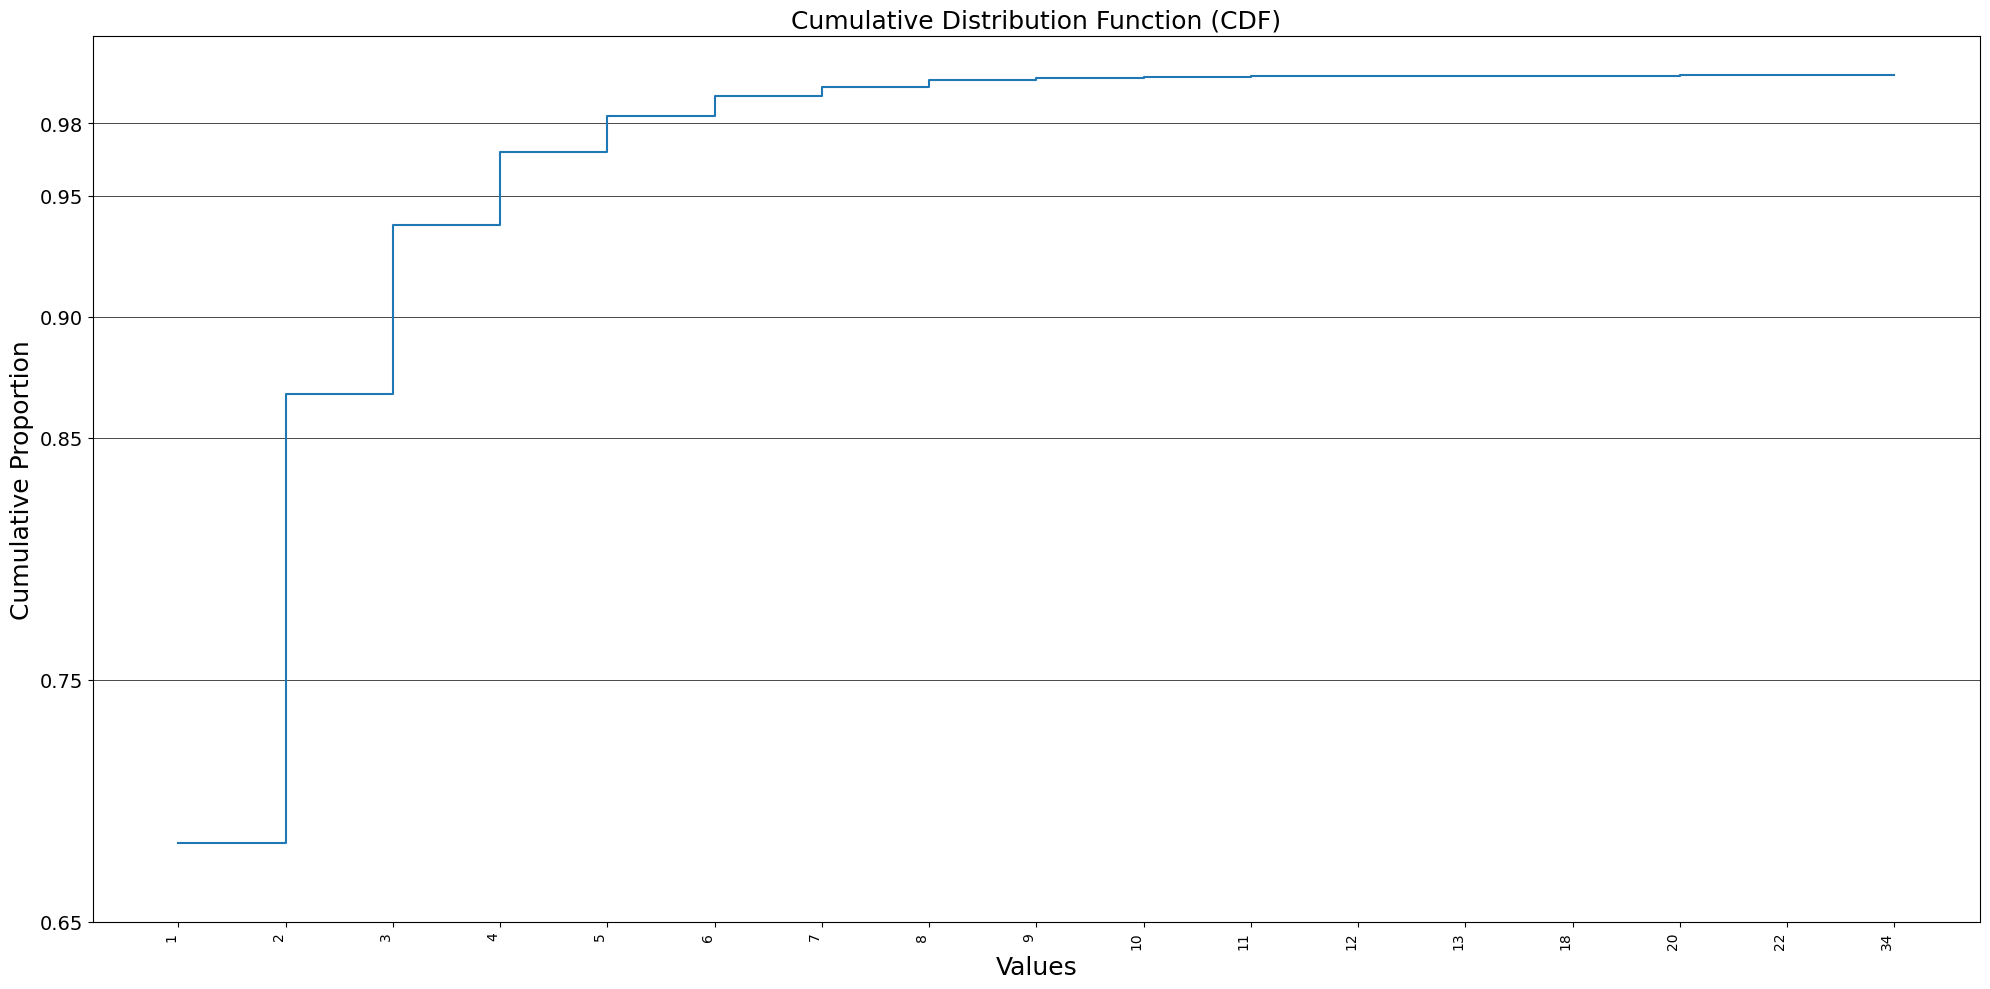

In [32]:
cumulative_freq = np.cumsum(count_of_counts_sorted.values)
total_freq = np.sum(count_of_counts_sorted.values)

# Calculate cumulative probabilities
cumulative_prob = cumulative_freq / total_freq
categories = [str(value) for value in count_of_counts_sorted.index]
plt.figure(figsize=(20, 10))  # Adjust the width and height (in inches) as needed
# Create the CDF plot
plt.step(categories, cumulative_prob, where='post')

percentiles = [ 0.65, 0.75, 0.85, 0.9, 0.95, 0.98]
plt.yticks(percentiles, fontsize=14)
# Add labels and title
plt.xlabel('Values', fontsize=18)
plt.xticks(rotation="vertical", ha='right')  # Adjust the rotation angle and alignment as needed
plt.ylabel('Cumulative Proportion', fontsize=18)
plt.title('Cumulative Distribution Function (CDF)', fontsize=18)
plt.grid(axis='y')
plt.gca().yaxis.grid(True, which='major', color='black', linestyle='-', linewidth=0.5)
plt.gca().set_yticks(percentiles, minor=True)
plt.tight_layout()

# Show the plot
plt.savefig("cdfAfterDrop.pdf", bbox_inches="tight")
plt.show()

In [33]:
df = pd.read_pickle("balancedCertPrufaDomainMatch.pkl")

In [35]:
df_double_balanced = balance_dataset(df)

In [37]:
df[df["phish"] == True]

,names,serial_number,subject_common_name,subject_country,subject_locality,subject_province,subject_organization,subject_num_fields,apple_ever_valid,microsoft_ever_valid,...,ocsp_urls,notice_numbers,directory_names,extended_key_usage,issuer_org,signed_certificate_timestamps,phish_matches,tranco_matches,phish,tranco
2,[denkc.shop],366504857763249856277849125738975780317575,denkc.shop,,,,,1,True,True,...,True,-1,[],True,Let's Encrypt,"[{'version': 0, 'log_id': b'\xb7>\xfb$\xdf\x9c...",[denkc.shop],[],1,0
3,"[uspick.top, uspicu.top, uspidi.top, uspikh.to...",292256474545241961098923632371890089111625,ususcu.top,,,,,1,True,True,...,True,-1,[],True,Let's Encrypt,"[{'version': 0, 'log_id': b'z2\x8cT\xd8\xb7-\x...","[ususyr.top, ususyi.top, ususie.top, usplob.to...",[],1,0
7,"[b247.com.vn, mail.b247.com.vn, www.b247.com.vn]",284738735543501994713565001286746028311459,b247.com.vn,,,,,1,True,True,...,True,-1,[],True,Let's Encrypt,[],[b247.com.vn],[],1,0
22,"[*.apprealizecards.com, apprealizecards.com]",359134860649975121230515155066068736172311,apprealizecards.com,,,,,1,True,True,...,True,-1,[],True,Let's Encrypt,"[{'version': 0, 'log_id': b'\xb7>\xfb$\xdf\x9c...",[apprealizecards.com],[],1,0
26,"[*.sibforms.com, sibforms.com]",268489258136984613324009596124996685628369,sibforms.com,,,,,1,True,True,...,True,-1,[],True,Let's Encrypt,[],"[c03aeb68.sibforms.com, 71f89f8d.sibforms.com,...",[sibforms.com],1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79089,"[analytics.twitter.com, api-stream.twitter.com...",17258337531727365225116453162392398380,twitter.com,US,San Francisco,California,"Twitter, Inc.",5,True,True,...,True,-1,[],True,DigiCert Inc,[],[t.co],"[t.co, twitter.com]",1,1
79091,"[analytics.twitter.com, api-stream.twitter.com...",11173271892332299871760991813684555355,twitter.com,US,San Francisco,California,"Twitter, Inc.",5,True,True,...,True,-1,[],True,DigiCert Inc,[],[t.co],"[t.co, twitter.com]",1,1
79094,"[analytics.twitter.com, api-stream.twitter.com...",7245731854804758527180686278590402059,twitter.com,US,San Francisco,California,"Twitter, Inc.",5,True,True,...,True,-1,[],True,DigiCert Inc,"[{'version': 0, 'log_id': b'\xe8>\xd0\xda>\xf5...",[t.co],"[t.co, twitter.com]",1,1
79101,"[analytics.twitter.com, api-stream.twitter.com...",2230225441399854941493020193238851678,twitter.com,US,San Francisco,California,"Twitter, Inc.",5,True,True,...,True,-1,[],True,DigiCert Inc,[],[t.co],"[t.co, twitter.com]",1,1


In [40]:
def label_phish(lst):
    if len(lst) > 0:
        return 1
    else:
        return 0

df = pd.read_pickle("balancedCertPrufa.pkl")

# df = pd.read_pickle("noTrancoPhishMatch.pkl")
# df = df.sample(n=10, random_state=42)
print(df.shape)
filt_phish = Filter(create_phish_set())
filt_tranco = Filter(create_tranco_set())
df[['phish_matches', 'tranco_matches']] = df['names'].apply(
    lambda x: pd.Series(check_domains(x, blocklist, whitelist, filt_phish, filt_tranco),
                        index=['phish_matches', 'tranco_matches'])
)
print(df.columns)
# print(f"seconds: {time.time() - start}")
# df.to_pickle("featuresCertPrufaDomainMatch.pkl")
df.reset_index(drop=True, inplace=True)
df['phish_matches'] = df['phish_matches'].apply(lambda x: list(set(x)))
df['tranco_matches'] = df['tranco_matches'].apply(lambda x: list(set(x)))
filtered_cond = df[
    (df['phish_matches'].apply(lambda x: len(x) > 1))
    | (df['tranco_matches'].apply(lambda x: len(x) > 1))
    | ((df['tranco_matches'].apply(lambda x: len(x) == 0)) & (df['phish_matches'].apply(lambda x: len(x) == 0)))
    | ((df['tranco_matches'].apply(lambda x: len(x) == 1)) & (df['phish_matches'].apply(lambda x: len(x) == 1)))]
filtered_df = df.drop(filtered_cond.index)
filtered_df['phish'] = filtered_df['phish_matches'].apply(lambda x: label_phish(x))
filtered_df['tranco'] = filtered_df['tranco_matches'].apply(lambda x: label_phish(x))
# filtered_df.to_pickle("featuresCertPrufaDomainMatch.pkl")
print(filtered_df.shape)
filtered_df.to_pickle("balancedCertPrufaDomainMatch.pkl")

(79209, 39)


/tmp/ipykernel_2639169/2092036625.py:104: FutureWarning: The default value of regex will change from True to False in a future version.
  phish['fullDomain'] = phish['fullDomain'].str.replace('www.', '')


Index(['names', 'serial_number', 'subject_common_name', 'subject_country',
       'subject_locality', 'subject_province', 'subject_organization',
       'subject_num_fields', 'apple_ever_valid', 'microsoft_ever_valid',
       'nss_ever_valid', 'validation_level', 'length_seconds', 'not_after',
       'not_before', 'crl_distribution_points', 'dns_names',
       'key_algorithm_name', 'version', 'signature_algorithm_name',
       'issuer_dn', 'issuer_common_name', 'authority_info_access',
       'certificate_policies', 'basic_constraints', 'key_usage_present',
       'key_usage_value', 'extended_key_usage_present',
       'signed_certificate_timestamp', 'authority_key_id', 'critical',
       'in_tranco', 'in_phish', 'ocsp_urls', 'notice_numbers',
       'directory_names', 'extended_key_usage', 'issuer_org',
       'signed_certificate_timestamps', 'phish_matches', 'tranco_matches'],
      dtype='object')
(67970, 43)


In [53]:
filteredCertPrufa = pd.read_pickle("filteredCertPrufa.pkl")
filteredCertPrufa

,names,serial_number,subject_common_name,subject_country,subject_locality,subject_province,subject_organization,subject_num_fields,apple_ever_valid,microsoft_ever_valid,...,authority_key_id,critical,in_tranco,in_phish,ocsp_urls,notice_numbers,directory_names,extended_key_usage,issuer_org,signed_certificate_timestamps
496,"[*.iherb.biz, iherb.biz]",400977141667832960674207135558527647498263,*.iherb.biz,,,,,1,True,True,...,True,None,False,False,True,-1,[],True,Let's Encrypt,[]
504,"[*.flashscore.co, flashscore.co]",311390029314026084051114153613681964773357,*.flashscore.co,,,,,1,True,True,...,True,None,False,False,True,-1,[],True,Let's Encrypt,[]
515,[denkc.shop],366504857763249856277849125738975780317575,denkc.shop,,,,,1,True,True,...,True,None,False,True,True,-1,[],True,Let's Encrypt,"[{'version': 0, 'log_id': b'\xb7>\xfb$\xdf\x9c..."
701,"[uspick.top, uspicu.top, uspidi.top, uspikh.to...",292256474545241961098923632371890089111625,ususcu.top,,,,,1,True,True,...,True,None,False,False,True,-1,[],True,Let's Encrypt,"[{'version': 0, 'log_id': b'z2\x8cT\xd8\xb7-\x..."
702,"[*.escortbabylon.net, escortbabylon.net]",197551658745025791587170417371140587467,escortbabylon.net,,,,,1,True,True,...,True,None,False,False,True,-1,[],True,Google Trust Services LLC,"[{'version': 0, 'log_id': b'z2\x8cT\xd8\xb7-\x..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992555,"[dl.hitava.ir, hitava.ir, manager.hitava.ir]",21792345402629533913784223078269556652123531,hitava.ir,,,,,1,False,False,...,True,None,False,False,True,-1,[],True,(STAGING) Let's Encrypt,[]
1892750,"[dl.hitava.ir, hitava.ir, manager.hitava.ir]",21804024841136539501837843257813772654259931,hitava.ir,,,,,1,False,False,...,True,None,False,False,True,-1,[],True,(STAGING) Let's Encrypt,[]
619010,"[dl.hitava.ir, hitava.ir, manager.hitava.ir]",405201714776568121846187284932507646748667,hitava.ir,,,,,1,True,True,...,True,None,False,False,True,-1,[],True,Let's Encrypt,"[{'version': 0, 'log_id': b'\xb7>\xfb$\xdf\x9c..."
840578,"[dl.hitava.ir, hitava.ir, manager.hitava.ir]",21817090175265403469026919976137964572235169,hitava.ir,,,,,1,False,False,...,True,None,False,False,True,-1,[],True,(STAGING) Let's Encrypt,[]


In [57]:
filt_phish = Filter(create_phish_set())
filt_tranco = Filter(create_tranco_set())
filteredCertPrufa[['phish_matches', 'tranco_matches']] = filteredCertPrufa['names'].apply(
    lambda x: pd.Series(check_domains(x, blocklist, whitelist, filt_phish, filt_tranco),
                        index=['phish_matches', 'tranco_matches']) 
)

/tmp/ipykernel_2639169/2092036625.py:104: FutureWarning: The default value of regex will change from True to False in a future version.
  phish['fullDomain'] = phish['fullDomain'].str.replace('www.', '')


In [82]:
filteredCertPrufa['phish_matches'] = filteredCertPrufa['phish_matches'].apply(lambda x: list(set(x)))
filteredCertPrufa['tranco_matches'] = filteredCertPrufa['tranco_matches'].apply(lambda x: list(set(x)))

In [107]:
filteredCertPrufa[(filteredCertPrufa['tranco_matches'].apply(lambda x: len(x) == 1)) & (filteredCertPrufa['phish_matches'].apply(lambda x: len(x) == 1))]

,names,serial_number,subject_common_name,subject_country,subject_locality,subject_province,subject_organization,subject_num_fields,apple_ever_valid,microsoft_ever_valid,...,in_tranco,in_phish,ocsp_urls,notice_numbers,directory_names,extended_key_usage,issuer_org,signed_certificate_timestamps,phish_matches,tranco_matches
9217,"[*.myshopify.com, myshopify.com]",275887905609405736276021927457574215581256,*.myshopify.com,,,,,1,True,True,...,False,True,True,-1,[],True,Let's Encrypt,[],[promo-livelo-paravoce.myshopify.com],[myshopify.com]
27383,"[*.asia.qualtrics.com, *.au1.qualtrics.com, *....",21076415465641755659450048705816906701,*.qualtrics.com,US,Provo,Utah,"Qualtrics, LLC",5,True,True,...,False,False,True,-1,[],True,DigiCert Inc,"[{'version': 0, 'log_id': b'\xe8>\xd0\xda>\xf5...",[qsnetwork.az1.qualtrics.com],[qualtrics.com]
33973,[forms.gle],331775466372213239121663828232204779126,forms.gle,,,,,1,True,True,...,True,True,True,-1,[],True,Google Trust Services LLC,"[{'version': 0, 'log_id': b'\xb3sw\x07\xe1\x84...",[forms.gle],[forms.gle]
37554,"[stats.g.doubleclick.net, t.co]",3,stats.g.doubleclick.net,CN,,,,2,False,False,...,False,False,False,-1,[],False,,[],[t.co],[t.co]
39961,"[app.linklist.bio, linklist.bio]",403036656884871860008392092649350646093490,linklist.bio,,,,,1,True,True,...,False,False,True,-1,[],True,Let's Encrypt,"[{'version': 0, 'log_id': b'z2\x8cT\xd8\xb7-\x...",[linklist.bio],[linklist.bio]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821532,"[*.googleadservices.com, googleadservices.com]",232816802430290765594877731831213405281,*.googleadservices.com,,,,,1,True,True,...,False,False,True,-1,[],True,Google Trust Services LLC,[],[googleadservices.com],[googleadservices.com]
1522803,"[*.googleadservices.com, googleadservices.com]",257981821553811796720096023810847845565,*.googleadservices.com,,,,,1,True,True,...,False,False,True,-1,[],True,Google Trust Services LLC,[],[googleadservices.com],[googleadservices.com]
1737047,"[*.googleadservices.com, googleadservices.com]",11767565878318125016074681633862565834,*.googleadservices.com,,,,,1,True,True,...,False,False,True,-1,[],True,Google Trust Services LLC,"[{'version': 0, 'log_id': b'\xb3sw\x07\xe1\x84...",[googleadservices.com],[googleadservices.com]
960781,"[*.googleadservices.com, googleadservices.com]",267104089201831720525506463315167906036,*.googleadservices.com,,,,,1,True,True,...,False,False,True,-1,[],True,Google Trust Services LLC,[],[googleadservices.com],[googleadservices.com]


In [54]:
filteredWithDomainMatchNewLabel = pd.read_pickle("filteredWithDomainMatchNewLabel.pkl")
filteredWithDomainMatchNewLabel

,names,serial_number,subject_common_name,subject_country,subject_locality,subject_province,subject_organization,subject_num_fields,apple_ever_valid,microsoft_ever_valid,...,ocsp_urls,notice_numbers,directory_names,extended_key_usage,issuer_org,signed_certificate_timestamps,phish_matches,tranco_matches,phish,tranco
0,"[*.iherb.biz, iherb.biz]",400977141667832960674207135558527647498263,*.iherb.biz,,,,,1,True,True,...,True,-1,[],True,Let's Encrypt,[],[],[iherb.biz],0,1
1,"[*.flashscore.co, flashscore.co]",311390029314026084051114153613681964773357,*.flashscore.co,,,,,1,True,True,...,True,-1,[],True,Let's Encrypt,[],[],[flashscore.co],0,1
2,[denkc.shop],366504857763249856277849125738975780317575,denkc.shop,,,,,1,True,True,...,True,-1,[],True,Let's Encrypt,"[{'version': 0, 'log_id': b'\xb7>\xfb$\xdf\x9c...",[denkc.shop],[],1,0
4,"[*.escortbabylon.net, escortbabylon.net]",197551658745025791587170417371140587467,escortbabylon.net,,,,,1,True,True,...,True,-1,[],True,Google Trust Services LLC,"[{'version': 0, 'log_id': b'z2\x8cT\xd8\xb7-\x...",[],[escortbabylon.net],0,1
5,[adstreamer.ru],262931341074434096513149468327989806654836,adstreamer.ru,,,,,1,True,True,...,True,-1,[],True,Let's Encrypt,[],[],[adstreamer.ru],0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79191,"[dl.hitava.ir, hitava.ir, manager.hitava.ir]",21792345402629533913784223078269556652123531,hitava.ir,,,,,1,False,False,...,True,-1,[],True,(STAGING) Let's Encrypt,[],[],[hitava.ir],0,1
79192,"[dl.hitava.ir, hitava.ir, manager.hitava.ir]",21804024841136539501837843257813772654259931,hitava.ir,,,,,1,False,False,...,True,-1,[],True,(STAGING) Let's Encrypt,[],[],[hitava.ir],0,1
79193,"[dl.hitava.ir, hitava.ir, manager.hitava.ir]",405201714776568121846187284932507646748667,hitava.ir,,,,,1,True,True,...,True,-1,[],True,Let's Encrypt,"[{'version': 0, 'log_id': b'\xb7>\xfb$\xdf\x9c...",[],[hitava.ir],0,1
79194,"[dl.hitava.ir, hitava.ir, manager.hitava.ir]",21817090175265403469026919976137964572235169,hitava.ir,,,,,1,False,False,...,True,-1,[],True,(STAGING) Let's Encrypt,[],[],[hitava.ir],0,1


In [55]:
featuresWithDomainMatchNewLabel = pd.read_pickle("featuresWithDomainMatchNewLabel.pkl")
featuresWithDomainMatchNewLabel

,names,serial_number,subject_common_name,subject_country,subject_locality,subject_province,subject_organization,subject_num_fields,apple_ever_valid,microsoft_ever_valid,...,len_issuer_dn,issuer_has_common_name,subject_is_empty,valid_timestamps,lcs_sans,lcs_sans_normed,crl_dist_point_present,not_before_date,not_after_date,domain
0,[denkc.shop],366504857763249856277849125738975780317575,denkc.shop,,,,,1,True,True,...,28,True,False,False,0,0.000000,False,2023-03-29 14:43:32,2023-06-27 14:43:31,denkc.shop
1,"[b247.com.vn, mail.b247.com.vn, www.b247.com.vn]",284738735543501994713565001286746028311459,b247.com.vn,,,,,1,True,True,...,28,True,False,False,11,0.687500,False,2023-06-02 17:20:28,2023-08-31 17:20:27,b247.com.vn
2,"[*.apprealizecards.com, apprealizecards.com]",359134860649975121230515155066068736172311,apprealizecards.com,,,,,1,True,True,...,28,True,False,False,21,1.000000,False,2023-09-22 23:10:15,2023-12-21 23:10:14,apprealizecards.com
3,"[acopgdywzr.duckdns.org, akkqpvukcp.duckdns.or...",341994358809335598613652640413025433400605,ikcwnlnyba.duckdns.org,,,,,1,True,True,...,28,True,False,False,12,0.545455,False,2023-03-28 06:00:27,2023-06-26 06:00:26,cqouskkrev.duckdns.org
4,"[*.24904122.workers.dev, 24904122.workers.dev]",275079334922121573454224969746097883665061,*.24904122.workers.dev,,,,,1,True,True,...,28,True,False,False,22,1.000000,False,2022-10-27 18:01:37,2023-01-25 18:01:36,logn-maile-0979.24904122.workers.dev
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18579,"[ak-staging-www.telcel.com, m.telcel.com, telc...",15483236415332984309485514108940842107,www.telcel.com,MX,Ciudad de Mexico,,Radiomovil DIPSA S.A. de C.V,6,True,True,...,89,True,False,False,11,0.440000,True,2022-03-18 00:00:00,2023-03-18 23:59:59,telcel.com
18580,"[*.heytapimg.com, heytapimg.com]",3680867031758445497046748679738962940,*.heytapimg.com,,,,,1,True,True,...,42,True,False,False,15,1.000000,True,2022-06-07 00:00:00,2023-07-06 23:59:59,heytapimg.com
18581,"[lottopcso.com, www.lottopcso.com]",315324778201205046174724217765522769406734,lottopcso.com,,,,,1,True,True,...,28,True,False,False,13,0.764706,False,2023-05-02 04:26:43,2023-07-31 04:26:42,lottopcso.com
18582,"[*.webpt.com, webpt.com]",20532029326546912511627017946765057203,*.webpt.com,,,,,1,True,True,...,38,True,False,False,11,1.000000,True,2023-02-08 00:00:00,2023-06-21 23:59:59,webpt.com


In [56]:
featuresCertAndDomainNewLabel = pd.read_pickle("featuresCertAndDomainNewLabel.pkl")
featuresCertAndDomainNewLabel

,names,serial_number,subject_common_name,subject_country,subject_locality,subject_province,subject_organization,subject_num_fields,apple_ever_valid,microsoft_ever_valid,...,mean_len_subdomains,valid_tld_iana,has_single_char_subdomain,char_diversity,alphabet_size,has_wildcard_san,is_wildcard_match,domain_pred,token_is_tld_new,new_sus_keyword
0,[denkc.shop],366504857763249856277849125738975780317575,denkc.shop,,,,,1,True,True,...,0.0,True,False,1.000000,9,False,False,0.767163,False,False
1,"[b247.com.vn, mail.b247.com.vn, www.b247.com.vn]",284738735543501994713565001286746028311459,b247.com.vn,,,,,1,True,True,...,4.0,True,False,1.000000,9,False,False,0.286464,True,False
2,"[*.apprealizecards.com, apprealizecards.com]",359134860649975121230515155066068736172311,apprealizecards.com,,,,,1,True,True,...,0.0,True,False,0.666667,12,True,False,0.062415,False,True
3,"[acopgdywzr.duckdns.org, akkqpvukcp.duckdns.or...",341994358809335598613652640413025433400605,ikcwnlnyba.duckdns.org,,,,,1,True,True,...,10.0,True,False,0.600000,12,False,False,0.996184,False,False
4,"[*.24904122.workers.dev, 24904122.workers.dev]",275079334922121573454224969746097883665061,*.24904122.workers.dev,,,,,1,True,True,...,11.5,True,False,0.636364,21,True,True,0.999883,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18579,"[ak-staging-www.telcel.com, m.telcel.com, telc...",15483236415332984309485514108940842107,www.telcel.com,MX,Ciudad de Mexico,,Radiomovil DIPSA S.A. de C.V,6,True,True,...,0.0,True,False,0.666667,6,False,False,0.062415,False,True
18580,"[*.heytapimg.com, heytapimg.com]",3680867031758445497046748679738962940,*.heytapimg.com,,,,,1,True,True,...,0.0,True,False,0.916667,11,True,False,0.062415,False,True
18581,"[lottopcso.com, www.lottopcso.com]",315324778201205046174724217765522769406734,lottopcso.com,,,,,1,True,True,...,0.0,True,False,0.583333,7,False,False,0.062415,False,False
18582,"[*.webpt.com, webpt.com]",20532029326546912511627017946765057203,*.webpt.com,,,,,1,True,True,...,0.0,True,False,1.000000,8,True,False,0.062415,False,False


## T-test analysis

In [1]:
import scipy.stats

In [17]:
df

,names,serial_number,subject_common_name,subject_country,subject_locality,subject_province,subject_organization,subject_num_fields,apple_ever_valid,microsoft_ever_valid,...,san_is_international,san_frac_vowels,san_frac_digits,san_has_digit_only_subdomain,san_mean_len_subdomains,san_valid_tld_iana,san_has_single_char_subdomain,san_char_diversity,san_alphabet_size,domain_sent
0,[denkc.shop],366504857763249856277849125738975780317575,denkc.shop,,,,,1,True,True,...,0.0,0.222222,0.000000,0.0,0.000000,1.0,0.000000,1.000000,9,denk c shop
1,"[b247.com.vn, mail.b247.com.vn, www.b247.com.vn]",284738735543501994713565001286746028311459,b247.com.vn,,,,,1,True,True,...,0.0,0.147059,0.264706,0.0,3.833333,1.0,0.000000,0.382353,13,b247 com vn
2,"[*.apprealizecards.com, apprealizecards.com]",359134860649975121230515155066068736172311,apprealizecards.com,,,,,1,True,True,...,0.0,0.378378,0.000000,0.0,0.500000,1.0,0.500000,0.351351,13,app realize cards com
3,"[acopgdywzr.duckdns.org, akkqpvukcp.duckdns.or...",341994358809335598613652640413025433400605,ikcwnlnyba.duckdns.org,,,,,1,True,True,...,0.0,0.226000,0.000000,0.0,10.000000,1.0,0.000000,0.013000,26,cqouskkrev duck dns org
4,"[*.24904122.workers.dev, 24904122.workers.dev]",275079334922121573454224969746097883665061,*.24904122.workers.dev,,,,,1,True,True,...,0.0,0.162162,0.432432,1.0,6.250000,1.0,0.500000,0.378378,14,lognmaile0979 24904122 workers dev
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12011,"[*.flirt4free.com, flirt4free.com]",381930136059629160252552465383694618102562,*.flirt4free.com,,,,,1,True,True,...,0.0,0.296296,0.074074,0.0,0.500000,1.0,0.500000,0.407407,11,flirt4 free com
12012,"[deploy.clipsal.com, schneider-electric.com, u...",3316113809360953127948746858956096245,www.schneider-electric.com,FR,Rueil Malmaison,Île-de-France,SCHNEIDER ELECTRIC INDUSTRIES SAS,5,True,True,...,0.0,0.329545,0.000000,0.0,3.500000,1.0,0.000000,0.227273,20,schneider electric com
12013,"[*.integration.hotmart.com, hotmart.com, integ...",347205169830656985798470596005562563320018,*.integration.hotmart.com,,,,,1,True,True,...,0.0,0.358491,0.000000,0.0,5.666667,1.0,0.333333,0.226415,12,hot mart com
12014,"[*.asset.ict.iau.ir, *.associations.iau.ir, *....",351643995823233563543089030412369677562655,*.asset.ict.iau.ir,,,,,1,True,True,...,0.0,0.524444,0.000000,0.0,3.075000,1.0,0.950000,0.106667,24,iau ir


In [23]:
df = pd.read_pickle("balanced_final.pkl")
t_statistic, p_value = scipy.stats.ttest_ind(np.log(df[df["phish"] == True].domain_len), np.log(df[df["phish"] == False].domain_len))
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Make a decision based on the p-value and a chosen significance level (e.g., 0.05)
if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the groups.")

t-statistic: 69.91981893405237
p-value: 0.0
Reject the null hypothesis. There is a significant difference between the groups.


In [24]:
t_statistic, p_value = scipy.stats.ttest_ind(np.log(df[df["phish"] == True].shannon_entropy), np.log(df[df["phish"] == False].shannon_entropy))
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Make a decision based on the p-value and a chosen significance level (e.g., 0.05)
if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the groups.")

t-statistic: 55.39652721637371
p-value: 0.0
Reject the null hypothesis. There is a significant difference between the groups.


In [25]:
t_statistic, p_value = scipy.stats.ttest_ind(np.log(df[df["phish"] == True].alphabet_size), np.log(df[df["phish"] == False].alphabet_size))
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Make a decision based on the p-value and a chosen significance level (e.g., 0.05)
if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the groups.")

t-statistic: 61.59035447230521
p-value: 0.0
Reject the null hypothesis. There is a significant difference between the groups.


In [26]:
t_statistic, p_value = scipy.stats.ttest_ind(np.log(df[df["phish"] == True].char_diversity), np.log(df[df["phish"] == False].char_diversity))
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Make a decision based on the p-value and a chosen significance level (e.g., 0.05)
if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the groups.")

t-statistic: -47.30851450994344
p-value: 0.0
Reject the null hypothesis. There is a significant difference between the groups.
